In [42]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time, scienceplots
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [43]:
FIG_WIDTH = 7.5  # width of figure in inches (a4 width)

In [44]:
plt.style.use(['science'])
TARGET_FOLDER = "/home/masc12/dev/masc12-mthesis/eda/solar-eda/plots"

In [45]:
from astral.sun import sun # https://astral.readthedocs.io/en/latest/
from astral import LocationInfo
stgallen_city = LocationInfo('St. Gallen', 'Switzerland', 'Europe/Zurich', 47.424492554512014, 9.376722938498643)

In [46]:
solar = pd.read_csv('../../data/strom-stg-bismaerz25.csv', sep=';', encoding='utf-8', low_memory=False, parse_dates=['DateTime (Local Time)'])

# General

In [47]:
solar["Name"].unique(), solar["Name"].unique().shape

(array(['Primarschule St.Leonhard', 'Primarschule Schönenwegen',
        'Sturzeneggstrasse 40', 'Werkhof St.Galler Stadtwerke',
        'Sonnmattstrasse 23', 'Future Champs Ostschweiz',
        'Unterwerk St.Gallen-Ost', 'Kirche Halden', 'Containerbau Lattich',
        'Sturzeneggstrasse 36', 'Sturzeneggstrasse 38'], dtype=object),
 (11,))

In [48]:
solar["Name des Smart-Me Zählers"].unique(), solar["Name des Smart-Me Zählers"].unique().shape

(array(['PV Vadianstrasse 49', 'PV Zürcher Strasse 67',
        'PV Sturzeneggstrasse 40', 'PV Steinachstrasse 47 Olma',
        'PV Steinachstrasse 49', 'PV Sonnmattstrasse 23',
        'PV Steinachstrasse 47 Spital', 'PV Kunklerstrasse 1',
        'PV Martinsbruggstrasse 84 UW Ost',
        'PV Oberhaldenstrasse 25 Kirche Halden',
        'PV Güterbahnhofstrasse 7', 'PV Sturzeneggstrasse 36',
        'PV Sturzeneggstrasse 38'], dtype=object),
 (13,))

In [49]:
solar.columns, solar.columns.shape

(Index(['DateTime (Local Time)', 'smart-me ID', 'Name',
        'Name des Smart-Me Zählers', 'Additional Energy Import',
        'Active Energy Import Total', 'Additional Energy Export',
        'Active Energy Export Total', 'Unit', 'Link', 'Modultyp',
        'Leistung in kWp', 'Anzahl Module', 'Leistung / Modul in Wp',
        'Wechselrichterleistung in kVA', 'Fläche in m2', 'Geo Shape',
        'Geo Point'],
       dtype='object'),
 (18,))

# Data Validation

See `solar_validation.ipynb` for more details.

In [50]:
solar['datetime'] = solar["DateTime (Local Time)"].apply(lambda x: dt.datetime(x.year,x.month,x.day,x.hour,x.minute))
solarsubset = solar[(solar["Name"] == "Werkhof St.Galler Stadtwerke") & (solar["Name des Smart-Me Zählers"] == "PV Steinachstrasse 49")].copy()

In [51]:
# filter out data above theoretical maximum
theomax_15min_Wh = solarsubset["Leistung in kWp"].max() * (1/4) * 1000
solarsubset[solarsubset["Additional Energy Export"] > theomax_15min_Wh]
solarsubset = solarsubset[solarsubset["Additional Energy Export"] <= theomax_15min_Wh]

In [52]:
solarsubset.sort_values("datetime", inplace=True)
solarsubset.reset_index(inplace=True)

# Target Variable Statistics

In [53]:
# print(solarsubset[["Additional Energy Export"]].describe().to_latex())
solarsubset[["Additional Energy Export"]].describe()

,Additional Energy Export
count,77045.000000
mean,481.358707
std,879.226037
min,0.000000
25%,0.000000
50%,0.000000
75%,509.743000
max,4229.391000


High Frequency of Zero Export. More than half the 15-minute intervals register zero export, reflecting nighttime hours.

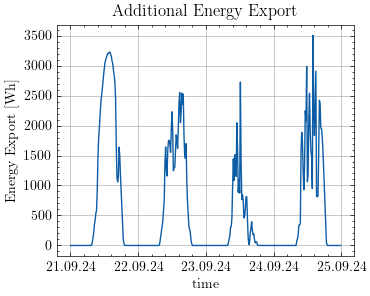

In [ ]:
small_data_subset = solarsubset[(solarsubset['datetime'] >= "2024-09-21 00:00:00") & (solarsubset['datetime'] <= "2024-09-24 23:59:00")].copy()
small_data_subset.sort_values(by='datetime', inplace=True)

xs = small_data_subset["datetime"]
ys = small_data_subset["Additional Energy Export"] 

fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 3))
# Plot for Additional Energy Export
ax.plot(xs, ys, label='Additional Energy Export')
ax.set(xlabel='time', ylabel='Energy Export [Wh]', title='Additional Energy Export')
ax.grid()
ax.set_axisbelow(True)

# Format x-axis as day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
ax.xaxis.set_major_locator(mdates.DayLocator())
fig.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/solar-additional-energy-export-2024-09-21-to-2024-09-24.png", dpi=300)
plt.show()

add dusk dawn for each day

In [55]:
custom_lambda = lambda date: sun(stgallen_city.observer, date, tzinfo=stgallen_city.timezone)

for i in ["dawn", "sunrise", "sunset", "dusk"]:
    solarsubset[i] = solarsubset["datetime"].apply(lambda x: custom_lambda(x)[i])
    solarsubset[i] = pd.to_datetime(solarsubset[i])  # Ensure datetime64[ns]

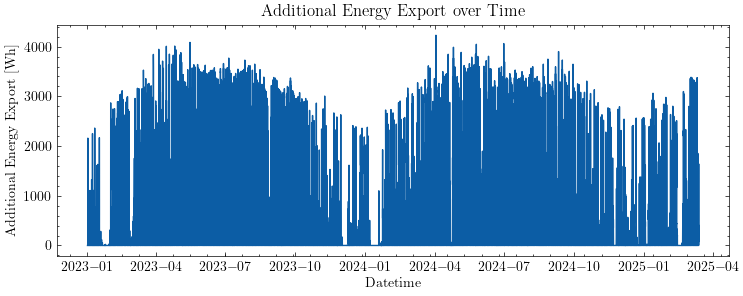

In [56]:
# 1. Time series of Additional Energy Export
plt.figure(figsize=(FIG_WIDTH, 3))
plt.plot(solarsubset['datetime'], solarsubset['Additional Energy Export'])
plt.title('Additional Energy Export over Time')
plt.xlabel('Datetime')
plt.ylabel('Additional Energy Export [Wh]')
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/solar-additional-energy-export.png", dpi=300)
plt.show()

During daylight, exports spike regularly up to ~4,000 Wh per interval while nights flatline at zero. There are clear seasonal blocks: high-density spikes in summer months, sparse and lower in winter.

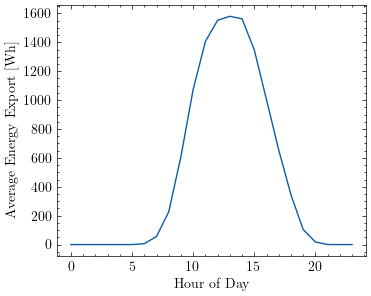

In [57]:
# 3. Diurnal pattern: average export by hour of day
solarsubset['hour'] = solarsubset['datetime'].dt.hour
hour_mean = solarsubset.groupby('hour')['Additional Energy Export'].mean()
plt.figure(figsize=(FIG_WIDTH/2, 3))
plt.plot(hour_mean.index, hour_mean.values)
# plt.title('Average Energy Export by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Export [Wh]')
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/solar-average-export-by-hour.png", dpi=300)
plt.show()
# caption: Average energy export by hour of day. The plot shows the average energy exported over 15 minutes for each hour of the day, indicating the diurnal pattern of solar energy generation.


Strong Diurnal Pattern. Average exports ramp up after sunrise, peak around 13:00–14:00, and drop off toward evening—matching typical sun-angle and irradiance curves.



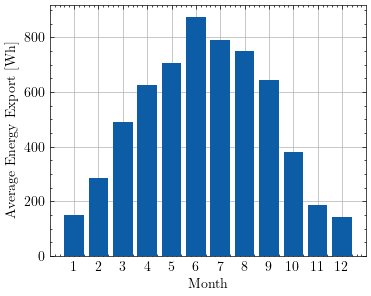

In [58]:
solarsubset['month'] = solarsubset['datetime'].dt.month
month_mean = solarsubset.groupby('month')['Additional Energy Export'].mean()
plt.figure(figsize=(FIG_WIDTH/2, 3))
plt.bar(month_mean.index, month_mean.values)
# plt.title('Average Energy Export by Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Export [Wh]')
plt.xticks(month_mean.index, range(1, 13))
plt.tight_layout(pad=0.5)
plt.grid()
plt.gca().set_axisbelow(True)
plt.savefig(f"{TARGET_FOLDER}/solar-average-export-by-month.png", dpi=300)
plt.show()
# caption: Average energy export by month. The plot shows the average energy exported over each month, indicating the seasonal pattern of solar energy generation.

Clear Seasonal Cycle. Monthly averages rise from ~150 Wh in January to ~875 Wh in June, then taper back to ~140 Wh by December, highlighting the strong influence of seasonal solar availability.

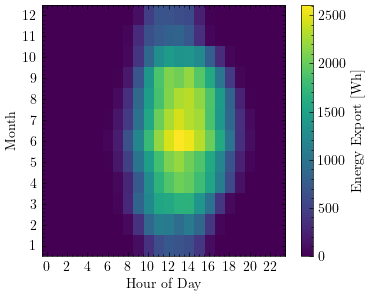

In [59]:
# 3. Heatmap: average export by month and hour
month_hour = solarsubset['Additional Energy Export'].groupby([solarsubset['datetime'].dt.month, solarsubset['datetime'].dt.hour]).mean().unstack()
# restrict hours to 4 to 22
# month_hour = month_hour.loc[:, 5:21]
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 3))
cax = ax.imshow(month_hour, aspect='auto', origin='lower')
# ax.set_title('Average Energy Export by Month and Hour')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Month')
ax.set_xticks(range(0, len(month_hour.columns), 2))
ax.set_xticklabels(month_hour.columns[::2])
ax.set_yticks(range(len(month_hour.index)))
ax.set_yticklabels(month_hour.index)
plt.colorbar(cax, label='Energy Export [Wh]', ax=ax)
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/heatmap-average-energy-export.png", dpi=300)
plt.show()

The 2D map of average export by month/hour highlights:

- Summer peaks (June–July) around 13:00–14:00.

- Shoulder months (April, May, September) have moderate midday production.

- Winter months show negligible export at all hours.

- Daily production span is narrowest in winter and widest in summer.

This combined seasonal–diurnal view pinpoints exactly when in the year and at what time of day the system performs best.

# Daily Production Start & End

In [60]:
solarsubset["dusk"]

0       2023-01-01 17:18:02.373245+01:00
1       2023-01-01 17:18:02.373245+01:00
2       2023-01-01 17:18:02.373245+01:00
3       2023-01-01 17:18:02.373245+01:00
4       2023-01-01 17:18:02.373245+01:00
                      ...               
77040   2025-03-13 18:56:12.538394+01:00
77041   2025-03-13 18:56:12.538394+01:00
77042   2025-03-13 18:56:12.538394+01:00
77043   2025-03-13 18:56:12.538394+01:00
77044   2025-03-13 18:56:12.538394+01:00
Name: dusk, Length: 77045, dtype: datetime64[ns, Europe/Zurich]

In [61]:
%%script False --no-raise-error
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 3))
ax = solarsubset[solarsubset["Additional Energy Export"] > 0] \
    .assign(hour_minute=solarsubset.datetime.dt.hour) \
    .groupby(solarsubset.datetime.dt.date)["hour_minute"] \
    .min() \
    .apply(lambda x: f"{int(x):02d}") \
    .value_counts() \
    .sort_index() \
    .plot(kind="bar", xlabel="Hour of Day", ylabel="Count")
    # .plot(kind="bar", title="Earliest Daily Export Time", xlabel="Time", ylabel="Count")
# axxticks to int
ax.tick_params(axis='x', rotation=0)
ax.set_xticklabels([int(x.get_text()) for x in ax.get_xticklabels()])
ax.grid()
ax.set_axisbelow(True)
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/earliest-daily-export-time.png", dpi=300)

Couldn't find program: 'False'


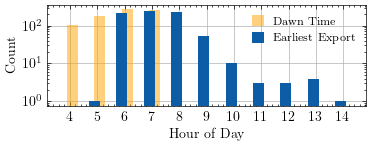

In [62]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 1.5))

# Earliest export time histogram
earliest_export_counts = solarsubset[solarsubset["Additional Energy Export"] > 0] \
    .assign(hour_minute=solarsubset.datetime.dt.hour) \
    .groupby(solarsubset.datetime.dt.date)["hour_minute"] \
    .min() \
    .apply(lambda x: f"{int(x):02d}") \
    .value_counts() \
    .sort_index()

# Dawn time histogram (assuming 'dawn' is in datetime format)
dawn_counts = solarsubset.groupby(solarsubset.datetime.dt.date)["dawn"] \
    .first() \
    .dt.hour \
    .apply(lambda x: f"{int(x):02d}") \
    .value_counts() \
    .sort_index()

# Convert to int index for consistent plotting
earliest_export_counts.index = earliest_export_counts.index.astype(int)
dawn_counts.index = dawn_counts.index.astype(int)

# Align both series to the same index range (optional, for better comparison)
all_hours = sorted(set(earliest_export_counts.index).union(dawn_counts.index))
earliest_export_counts = earliest_export_counts.reindex(all_hours, fill_value=0)
dawn_counts = dawn_counts.reindex(all_hours, fill_value=0)

# Plot both histograms
ax.bar(dawn_counts.index + 0.1, dawn_counts.values, width=0.4, label="Dawn Time", color='orange', alpha=0.5)
ax.bar(earliest_export_counts.index - 0.1, earliest_export_counts.values, width=0.4, label="Earliest Export")

# Axis formatting
ax.set_yscale('log')
# ax.set_ylim(0, 285)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Count")
ax.set_xticks(all_hours)
ax.tick_params(axis='x', rotation=0)
ax.grid()
ax.set_axisbelow(True)
ax.legend(handlelength=1, handleheight=1, fontsize="small")
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/earliest-export-vs-dawn.png", dpi=300)


In [63]:
solarsubset[(solarsubset["Additional Energy Export"] > 0) & (solarsubset.datetime.dt.hour <= 5)]

,index,DateTime (Local Time),smart-me ID,Name,Name des Smart-Me Zählers,Additional Energy Import,Active Energy Import Total,Additional Energy Export,Active Energy Export Total,Unit,...,Fläche in m2,Geo Shape,Geo Point,datetime,dawn,sunrise,sunset,dusk,hour,month
15858,20403,2023-06-15 05:45:00+02:00,115a4cd6-c5b2-d6a6-14dc-b03078644337,Werkhof St.Galler Stadtwerke,PV Steinachstrasse 49,0.135,12066.283,0.006,40432998.13,Wh,...,178,"{""coordinates"": [[[9.384719638540817, 47.43109...","47.4312365481, 9.38471976238",2023-06-15 05:45:00,2023-06-15 04:44:12.137194+02:00,2023-06-15 05:25:18.626771+02:00,2023-06-15 21:20:44.907250+02:00,2023-06-15 22:01:54.312926+02:00,5,6


In [64]:
%%script False --no-raise-error
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 3))
ax = solarsubset[solarsubset["Additional Energy Export"] > 0] \
    .assign(hour_minute=solarsubset.datetime.dt.hour) \
    .groupby(solarsubset.datetime.dt.date)["hour_minute"] \
    .max() \
    .apply(lambda x: f"{int(x):02d}") \
    .value_counts() \
    .sort_index() \
    .plot(kind="bar", xlabel="Hour of Day", ylabel="Count")
    # .plot(kind="bar", title="Latest Daily Export Time", xlabel="Time", ylabel="Count")
ax.tick_params(axis='x', rotation=0)
ax.grid()
ax.set_axisbelow(True)
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/latest-daily-export-time.png", dpi=300)

Couldn't find program: 'False'


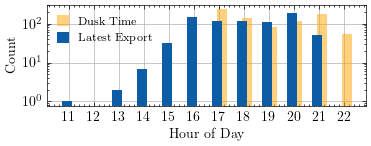

In [65]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 1.5)) 

# Latest export time histogram
latest_export_counts = solarsubset[solarsubset["Additional Energy Export"] > 0] \
    .assign(hour_minute=solarsubset.datetime.dt.hour) \
    .groupby(solarsubset.datetime.dt.date)["hour_minute"] \
    .max() \
    .apply(lambda x: f"{int(x):02d}") \
    .value_counts() \
    .sort_index()

# Dusk time histogram (assuming 'dusk' is a datetime column)
dusk_counts = solarsubset.groupby(solarsubset.datetime.dt.date)["dusk"] \
    .first() \
    .dt.hour \
    .apply(lambda x: f"{int(x):02d}") \
    .value_counts() \
    .sort_index()

# Convert index to int for alignment
latest_export_counts.index = latest_export_counts.index.astype(int)
dusk_counts.index = dusk_counts.index.astype(int)

# Align both series to the same set of hour bins
all_hours = list(range(11, 23))  # includes 12!
latest_export_counts = latest_export_counts.reindex(all_hours, fill_value=0)
dusk_counts = dusk_counts.reindex(all_hours, fill_value=0)


# Plot both histograms side by side
ax.bar(dusk_counts.index + 0.1, dusk_counts.values, width=0.4, label="Dusk Time", color='orange', alpha=0.5)
ax.bar(latest_export_counts.index - 0.1, latest_export_counts.values, width=0.4, label="Latest Export")

# Axis formatting
ax.set_yscale('log')
# ax.set_ylim(0, 285)
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Count")
ax.set_xticks(all_hours)
ax.tick_params(axis='x', rotation=0)
ax.grid()
ax.set_axisbelow(True)
ax.legend(handlelength=1, handleheight=1, fontsize="small")
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/latest-export-vs-dusk.png", dpi=300)

In [66]:
solarsubset[(solarsubset["Additional Energy Export"] > 0) & (solarsubset.datetime.dt.hour >= 21) & (solarsubset.datetime.dt.minute >= 30)]

,index,DateTime (Local Time),smart-me ID,Name,Name des Smart-Me Zählers,Additional Energy Import,Active Energy Import Total,Additional Energy Export,Active Energy Export Total,Unit,...,Fläche in m2,Geo Shape,Geo Point,datetime,dawn,sunrise,sunset,dusk,hour,month
17745,21591,2023-07-04 21:30:00+02:00,115a4cd6-c5b2-d6a6-14dc-b03078644337,Werkhof St.Galler Stadtwerke,PV Steinachstrasse 49,0.0,12080.924,0.198,4.216594e+07,Wh,...,178,"{""coordinates"": [[[9.384719638540817, 47.43109...","47.4312365481, 9.38471976238",2023-07-04 21:30:00,2023-07-04 04:50:53.197267+02:00,2023-07-04 05:31:35.492157+02:00,2023-07-04 21:21:51.223841+02:00,2023-07-04 22:02:27.759402+02:00,21,7


In [67]:
earliest = solarsubset[solarsubset["Additional Energy Export"] > 0]["datetime"].dt.time.min()
latest = solarsubset[solarsubset["Additional Energy Export"] > 0]["datetime"].dt.time.max()
earliest, latest

(datetime.time(5, 45), datetime.time(21, 30))

# Histogram

In [68]:
solarsubset[
    (solarsubset["datetime"] < solarsubset["dusk"].dt.tz_localize(None)) &
    (solarsubset["datetime"] > solarsubset["dawn"].dt.tz_localize(None))
][["Additional Energy Export"]].describe()

,Additional Energy Export
count,42299.000000
mean,876.764972
std,1030.228085
min,0.000000
25%,23.423500
50%,392.853000
75%,1543.618500
max,4229.391000


Bins: 43


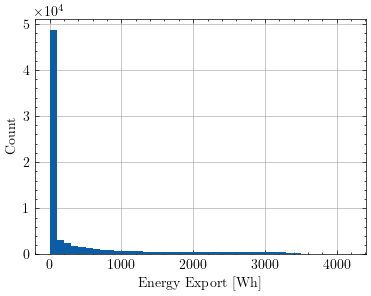

In [69]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 3))
ax = solarsubset["Additional Energy Export"].plot(
    kind='hist', 
    bins=np.arange(0, solarsubset["Additional Energy Export"].max(), 100),
    xlabel="Energy Export [Wh]", 
    ylabel="Count"
)

ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

ax.grid()
ax.set_axisbelow(True)
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/distribution-energy-export.png", dpi=300)
print("Bins:", len(np.arange(0, solarsubset["Additional Energy Export"].max(), 100)))

Bins: 43


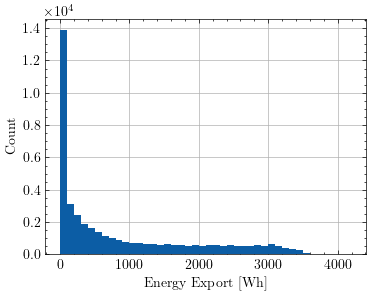

In [70]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 3))
ax = solarsubset[
    (solarsubset["datetime"] < solarsubset["dusk"].dt.tz_localize(None)) &
    (solarsubset["datetime"] > solarsubset["dawn"].dt.tz_localize(None)) &
    (solarsubset["Additional Energy Export"] >= 0)
]["Additional Energy Export"].plot(
    kind='hist', 
    bins=np.arange(0, solarsubset["Additional Energy Export"].max(), 100),
    xlabel="Energy Export [Wh]", 
    ylabel="Count"
)

ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

ax.grid()
ax.set_axisbelow(True)
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/distribution-energy-export-daylight.png", dpi=300)
print("Bins:", len(np.arange(0, solarsubset["Additional Energy Export"].max(), 100)))

Bins: 43


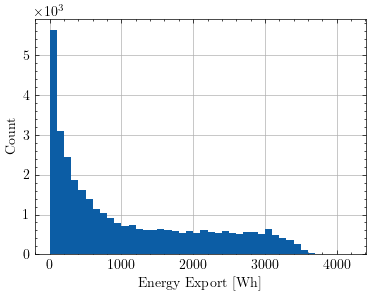

In [71]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 3))
ax = solarsubset[
    (solarsubset["Additional Energy Export"] > 0)
]["Additional Energy Export"].plot(
    kind='hist', 
    bins=np.arange(0, solarsubset["Additional Energy Export"].max(), 100),
    xlabel="Energy Export [Wh]", 
    ylabel="Count",
)

ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

ax.grid()
ax.set_axisbelow(True)
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/distribution-non-zero-energy-export.png", dpi=300)
print("Bins:", len(np.arange(0, solarsubset["Additional Energy Export"].max(), 100)))

Non-zero exports are skewed toward smaller values: most intervals export a few hundred Wh, but there's a long tail of occasional very high exports

In [72]:
solarsubset["Additional Energy Export"].max()

4229.391000002623

# Boxplots and Quantiles

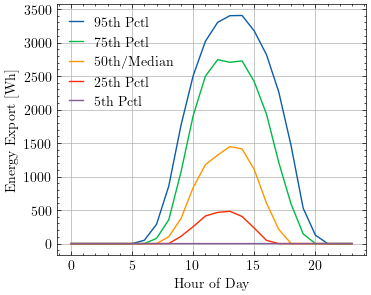

In [73]:
# 1. Quantile Diurnal Profiles
hourly_quantiles = solarsubset['Additional Energy Export'].groupby(solarsubset.datetime.dt.hour).quantile([0.05, 0.25, 0.5, 0.75, 0.95]).unstack()
plt.figure(figsize=(FIG_WIDTH/2, 3))
plt.plot(hourly_quantiles.index, hourly_quantiles[0.95], label='95th Pctl')
plt.plot(hourly_quantiles.index, hourly_quantiles[0.75], label='75th Pctl')
plt.plot(hourly_quantiles.index, hourly_quantiles[0.5], label='50th/Median')
plt.plot(hourly_quantiles.index, hourly_quantiles[0.25], label='25th Pctl')
plt.plot(hourly_quantiles.index, hourly_quantiles[0.05], label='5th Pctl')
# plt.title('Hourly Quantiles of Energy Export')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Export [Wh]')
leg = plt.legend(
    loc="upper left",
    columnspacing=1.5,
    handlelength=1,
)

leg.get_frame().set_facecolor("white")
leg.get_frame().set_alpha(0.8)

plt.grid()
plt.gca().set_axisbelow(True)
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/hourly-quantiles-energy-export.png", dpi=300)
plt.show()

Diurnal Spread (Quantiles)

- The 25th percentile curve shows that even during peak hours (~11–14 h) at least a small export occurs almost always.

- The median highlights typical midday outputs (~800–1 400 Wh).

- The 75th percentile rises to ~2700 Wh at noon, illustrating the potential on very sunny days.

77045 samples.


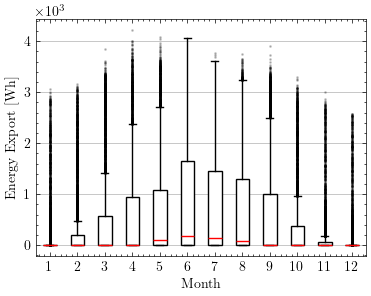

In [74]:
plt.figure(figsize=(FIG_WIDTH/2, 3))
monthly_data = [solarsubset['Additional Energy Export'][solarsubset.datetime.dt.month == m] for m in range(1, 13)]
plt.boxplot(
    monthly_data,
    showfliers=True, 
    patch_artist=True,
    boxprops=dict(facecolor='white', color='black'),
    medianprops=dict(color='red'),
    flierprops=dict(marker='o', markersize=1, markerfacecolor='black', linestyle='none', alpha=0.2),
)


# plt.title('Monthly Distribution of Energy Export')
plt.xlabel('Month')
plt.ylabel('Energy Export [Wh]')
plt.tight_layout()
plt.grid(axis='y')
plt.gca().set_axisbelow(True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

print(sum([len(m) for m in monthly_data]), "samples.")
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/monthly-boxplot-energy-export.png", dpi=300)
plt.show()

Month-by-Month Variability (Boxplots)

- June (Month 6) has the highest median (~200 Wh per interval) and the widest interquartile range (~0–1650 Wh), reflecting both high average irradiance and variable weather (sunny vs. cloudy days).

- Winter months (e.g., January, December) exhibit almost all zeros with very narrow boxes. Suggesting snow cover plus low sun angles.

- Shoulder months (April, May, September) show moderate median exports (~100–250 Wh) but broader spreads, indicating transitional seasonal variability.

803 samples.


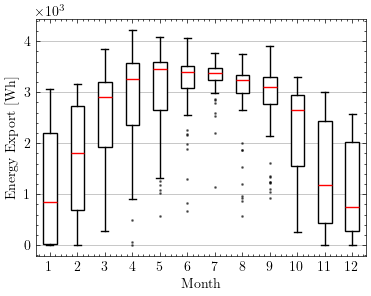

In [75]:
monthly_max_data = [solarsubset['Additional Energy Export'][solarsubset.datetime.dt.month == m].groupby([solarsubset['datetime'].dt.date]).max() for m in range(1, 13)]
plt.figure(figsize=(FIG_WIDTH/2, 3))
plt.boxplot(
    monthly_max_data,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='white', color='black'),
    medianprops=dict(color='red'),
    flierprops=dict(marker='o', markersize=1, markerfacecolor='black', linestyle='none', alpha=0.5),
)

# plt.title('Daily Maximum Energy Export by Month')
plt.xlabel('Month')
plt.ylabel('Energy Export [Wh]')
plt.tight_layout()
plt.grid(axis='y')
plt.gca().set_axisbelow(True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

print(sum([len(m) for m in monthly_max_data]), "samples.")
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/monthly-boxplot-daily-max-energy-export.png", dpi=300)
plt.show()

In [76]:
print("Total samples:", len(solarsubset))
print("# of 15 min intervals per day:", int((24*60)/15))
print("Theoretical amount of samples in monthly boxplot:", len(solarsubset) / int((24*60)/15))

Total samples: 77045
# of 15 min intervals per day: 96
Theoretical amount of samples in monthly boxplot: 802.5520833333334


Bins: 43
Total samples: 803


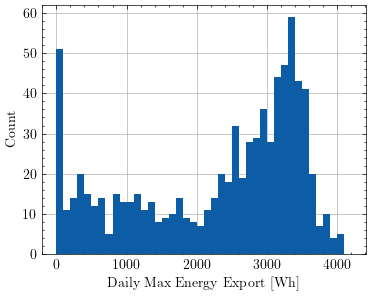

In [77]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 3))
daily_max = solarsubset['Additional Energy Export'].groupby([solarsubset["datetime"].dt.date]).max()
daily_max.index = pd.to_datetime(daily_max.index)
ax.hist(daily_max.dropna(), bins=np.arange(0, daily_max.max(), 100))
# ax.set_title('Histogram of Daily Maximum Energy Export')
ax.set_xlabel('Daily Max Energy Export [Wh]')
ax.set_ylabel('Count')
ax.grid()
ax.set_axisbelow(True)
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/histogram-daily-max-energy-export.png", dpi=300)
print("Bins:", len(np.arange(0, daily_max.max(), 100)))
print("Total samples:", len(daily_max.dropna()))

Histogram shows a bimodal structure: many days with very low maxima (cloudy/winter) and a cluster at high values (~3 000–3 500 Wh) during summer.

In [ ]:
len(daily_max[daily_max == 0]), len(daily_max[daily_max < 100])

(34, 51)

In [ ]:
# get percentage of daily_max[daily_max == 0] that are in winter months
winter_months = [12, 1, 2]
winter_days = daily_max[daily_max.index.month.isin(winter_months)]
print(len(winter_days[winter_days == 0]), "out of", len(daily_max[daily_max == 0]), "days are in winter months")
print("The other", len(daily_max[daily_max == 0])- len(winter_days[winter_days == 0]), "days are in months: ", daily_max[(daily_max == 0) & (~daily_max.index.month.isin(winter_months))].index.month.unique())

30 out of 34 days are in winter months
The other 4 days are in months:  Index([4, 11], dtype='int32', name='datetime')


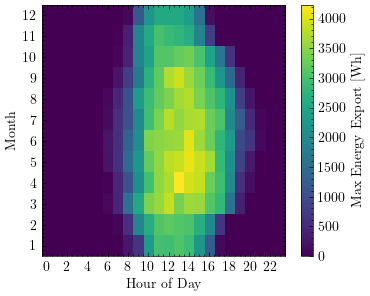

Max val during winter:  3167.545000001788


In [ ]:
fig, ax = plt.subplots(figsize=(FIG_WIDTH/2, 3))
month_hour = solarsubset['Additional Energy Export'].groupby([solarsubset['datetime'].dt.month, solarsubset['datetime'].dt.hour]).max().unstack()
# month_hour = month_hour.loc[:, 5:21]
cax = ax.imshow(month_hour, aspect='auto', origin='lower')
# ax.set_title('Average Energy Export by Month and Hour')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Month')
ax.set_xticks(range(0, len(month_hour.columns), 2))
ax.set_xticklabels(month_hour.columns[::2])
ax.set_yticks(range(len(month_hour.index)))
ax.set_yticklabels(month_hour.index)
plt.colorbar(cax, label='Max Energy Export [Wh]', ax=ax)
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/heatmap-max-energy-export.png", dpi=300)
plt.show()

# max in winter months
winter_days = daily_max[daily_max.index.month.isin(winter_months)]
print("Max val during winter: ", winter_days.max())

Heatmap shows that winter months still produce some energy, altough peak values are lower than in summer.

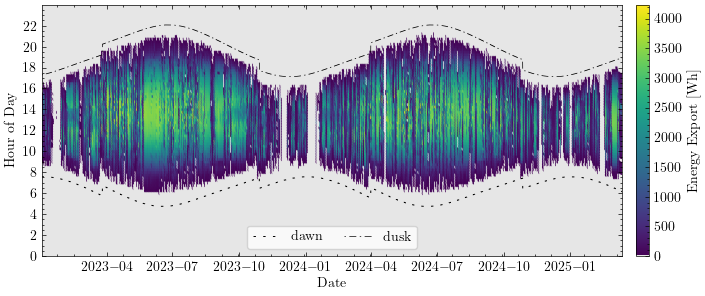

In [ ]:
base = plt.cm.viridis(np.linspace(0, 1, 256))
# 1b) Overwrite the very first color to white (RGBA)
base[0] = [.9, .9, .9, 1] 
white_viridis = LinearSegmentedColormap.from_list("white_viridis", base)

fig, ax = plt.subplots(figsize=(FIG_WIDTH, 3))

# scatter production colored by value
prod_secs = (
    solarsubset["datetime"].dt.hour * 3600 +
    solarsubset["datetime"].dt.minute * 60 +
    solarsubset["datetime"].dt.second
)
sc = ax.scatter(
    solarsubset["datetime"],
    prod_secs,
    c=solarsubset["Additional Energy Export"],
    cmap=white_viridis,
    s=8,
)

for i, col in enumerate(["dawn", "dusk"]):
    secs = (
        solarsubset[col].dt.hour * 3600 +
        solarsubset[col].dt.minute * 60 +
        solarsubset[col].dt.second
    )

    # Plot full-resolution line without markers
    ax.plot(
        solarsubset["datetime"],
        secs,
        label=col,
        color="black",
        linewidth= .7 if col == "dawn" else .5,
        linestyle = (0, (2.5, 7.5)) if col == "dawn" else (0, (2, 5, 10, 5)),
    )



# colorbar
cbar = fig.colorbar(sc, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("Energy Export [Wh]")

# y-axis formatting
ax.yaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: int(time.strftime("%H", time.gmtime(x))))
)

# legend with white, semi-transparent background
leg = ax.legend(
    loc="lower center",
    ncol=2,          
    frameon=True,
    columnspacing=1.5
)

# remove extra horizontal padding
ax.margins(x=0, y=0)

# ax.set_title("Energy Export with Sunrise/Sunset Times")
ax.set_ylabel("Hour of Day")
ax.set_xlabel("Date")

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/energy-export-sunrise-sunset.png", dpi=300)
plt.show()

Winter Compression: In December/January the envelope narrows and exports turn very pale, showing consistently low winter output.

Weather Texture: Vertical streaks of lighter red within the summer band reveal intermittent cloudiness even on long, bright days.